# 用BiLSTM-CRF模型进行实体抽取

这一波人工智能的繁荣发展，深度学习功不可没，几乎可以肯定地说，没有深度学习，就没有今天人工智能的欣欣向荣。自然而然的，深度学习在各个人工智能子领域迅速渗透，自然语言处理和知识图谱也不例外地大量使用深度学习方法。在实体抽取方面，深度学习同样表现卓绝，已成为当前最常用的和效果最优的方法。本文介绍了实体抽取中最经典的深度学习模型——BiLSTM-CRF模型。


In [1]:
import os

## BiLSTM-CRF 模型


BiLSTM-CRF（双向长短期记忆网络-条件随机场）模型在实体抽取任务中用得最多，是实体抽取任务中深度学习模型评测的基准，也是在BERT出现之前最好用的模型。在使用CRF进行实体抽取时，需要专家利用特征工程设计合适的特征函数，比如CRF++中的特征模板文件。BiLSTM-CRF则不需要利用特征工程，而是通过BiLSTM网络自动地从数据（训练语料）中学习出特征，并通过CRF计算标签的全局概率信息对输出词元序列进行解码，得到对应的标签序列。这正是深度学习方法相比于传统机器学习方法所具有的巨大优势。深度学习方法将算法人员从琐碎的特征工程中解放出来，专注于深度神经网络结构的创新，进而形成正向循环，推动了人工智能近年来的高速发展。

——珠峰书《知识图谱：认知智能理论与实战》 P117


BiLSTM-CRF 模型的详细解析及其理论基础，可参考珠峰书《知识图谱：认知智能理论与实战》 P118~122


## BiLSTM-CRF模型结构图

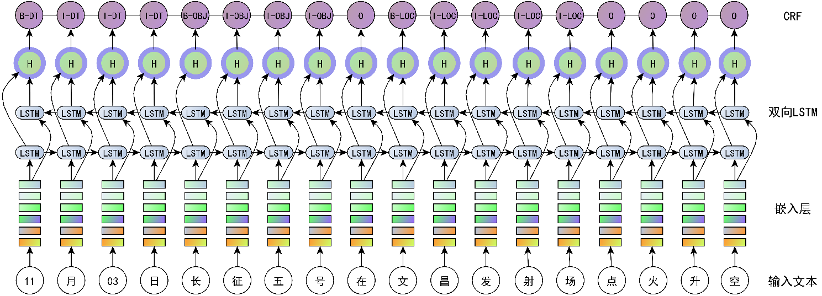


——珠峰书《知识图谱：认知智能理论与实战》图3-13， P118


In [2]:
import numpy as np

import paddle
from paddle import nn
from paddle.callbacks import EarlyStopping

飞桨框架在1.x 版本使用了静态图，并在 fluid 模块中提供了 CRF 有关的组件。但在飞桨2.x 中改为了动态图，并提醒 fluid 模块会被舍弃。
在珠峰书中，限于篇幅，并且以示例为目的，避免引入过多的其他依赖库，在CRF中选择使用了 paddle 的 fluid 模块的 CRF 组件。不过本文选用了飞桨2.x 的动态图模型构建方法，并因此引入了额外的PaddleNLP 模块。

有关 PaddleNLP 可参考官方文档：
- https://paddlenlp.readthedocs.io

In [3]:
import paddlenlp
from paddlenlp.layers import LinearChainCrf, LinearChainCrfLoss, ViterbiDecoder

In [4]:
paddle.__version__, paddlenlp.__version__

('2.3.2', '2.3.7')

## 数据准备

本例子使用 MSRA 发布的公开命名实体识别的语料，可以从【datasets/NER-MSRA】目录下获得处理好的数据集，包括训练语料train.txt和测试语料test.txt。语料的说明见该目录下的 readme。

### 读取数据



In [5]:
#载入数据

c2i = {'\001': 0}
t2i = {'O':0}

def read_data(filename, token2id, label2id):
    '''读入训练语料，并转化为id
    格式为适合crf++的格式：
        每行格式为 token\t标签
        空行表示句子结束
    @param filename: 语料文件名
    @param token2id: 词元到 id 的映射字典
    @param label2id：标签到 id 的映射字典
        '''
    data = []
    max_word_id = max([v for k, v in token2id.items()]) + 1
    max_label_id = max([v for k, v in label2id.items()]) + 1


    sent = []
    lbl = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if not line:
                data.append((sent, lbl))
                sent = []
                lbl = []
                continue
            c, t = line.split("\t")
            if c not in c2i:
                c2i[c] = max_word_id
                max_word_id += 1
            ci = c2i[c]

            if t not in t2i:
                t2i[t] = max_label_id
                max_label_id += 1
            ti = t2i[t]

            sent.append(ci)
            lbl.append(ti)
        if sent:
            data.append((sent, lbl))
    return data

train_data = read_data('./msra/train.txt', c2i, t2i)
print('train: ', len(train_data))
test_data = read_data('./msra/test.txt', c2i, t2i)
print('test: ', len(test_data))

print('words count:', len(c2i))
print('labels count:', len(t2i))



train:  45057
test:  3442
words count: 4856
labels count: 7


### 标签情况

In [6]:
t2i

{'O': 0,
 'B-LOC': 1,
 'I-LOC': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-PER': 5,
 'I-PER': 6}

### Paddle 的 Dataset 

将数据集转化为 Paddle 的 Dataset 格式，方便后续给模型使用

`paddle.io.Dataset` 是Paddle数据集的抽象类，需要实现如下两个方法：

- `__getitem__`: 根据给定索引获取数据集中指定样本，在 `paddle.io.DataLoader` 中需要使用此函数通过下标获取样本。

- `__len__`: 返回数据集样本个数， `paddle.io.BatchSampler` 中需要样本个数生成下标序列。


参考：https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/io/Dataset_cn.html

In [7]:
class TheDataset(paddle.io.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        sent, lbl, length = self.data[idx]
        return sent, length, lbl
    
    def __len__(self):
        return len(self.data)

### 转化为 Paddle 的 Dataset

In [8]:

def trans2TheDataset(data, max_seq_len):
    data2 = []
    for k, v  in data:
        klen = min(len(k), max_seq_len)
        if len(k) < max_seq_len:
            pad = [0] * (max_seq_len - len(k))
            k = k + pad
            v = v + pad
        elif len(k) > max_seq_len:
            k = k[:max_seq_len]
            v = v[:max_seq_len]
        data2 .append((np.asarray(k, dtype='int64'), np.asarray(v, dtype='int64'), np.asarray(klen, dtype='int64')))
    return TheDataset(data2)


### 创建数据集

由于 msra 数据集仅提供了 train 和 test，没有 dev 数据集。这里将 train 进行二八划分为 dev 和 train 两个数据集。

另外，在输入中需要对过长的输入句子进行截断，这里设置max_seq_len为255，在实际应用中可根据情况取值。

In [9]:

max_seq_len = 255


# train_data 拆分为 train 和 dev
train_data_count = len(train_data)
dev_data_count = int(train_data_count * 0.2)
train_data_count -= dev_data_count
print(train_data_count, dev_data_count)
dev_data = train_data[:dev_data_count]
train_data = train_data[dev_data_count:]
print(len(train_data), len(dev_data))

train_dataset = trans2TheDataset(train_data, max_seq_len)
dev_dataset = trans2TheDataset(dev_data, max_seq_len)
test_dataset = trans2TheDataset(test_data, max_seq_len)

print(len(train_dataset), len(dev_dataset), len(test_dataset))

36046 9011
36046 9011
36046 9011 3442


### 构建支持获取微批数据的 Dataloader

- `DataLoader`返回一个迭代器，该迭代器根据 batch_sampler 给定的顺序迭代一次给定的 dataset

- `DataLoader`支持单进程和多进程的数据加载方式，当 num_workers 大于0时，将使用多进程方式异步加载数据。

参考：https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/io/DataLoader_cn.html

In [10]:
batch_size = 32
# 加载数据
train_loader = paddle.io.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
dev_loader = paddle.io.DataLoader(dev_dataset, shuffle=False, batch_size=batch_size*2, drop_last=False)
test_loader = paddle.io.DataLoader(test_dataset, shuffle=False, batch_size=batch_size*8, drop_last=False)


for b in train_loader:
    break
x, l, y = b
x.shape, l.shape, y.shape

([32, 255], [32], [32, 255])

## 构建BiLSTM-CRF实体抽取模型


在《知识图谱：认知智能理论与实战》一书中，对实体的定义为：

*实体（Entity）：是指一种独立的、拥有清晰特征的、能够区别于其他事物的事物。在信息抽取、自然语言处理和知识图谱等领域，用来描述这些事物的信息即实体。实体可以是抽象的或者具体的。*

                                                         ——王文广 《知识图谱：认知智能理论与实战》 P81

这是对1996年MUC-6会议对命名实体的扩展。MUC组委会在当时提出的“命名实体”任务要求从文本中识别出所有的人物名称（人名）、组织机构名称（机构名）和地理位置名称（地名），以及时间、货币和百分数的表述。如果仅仅识别人名、地名、机构名等实体的话，常见的分词库（如 jieba、HanLP、LAC 等）都支持的，可以直接使用这些库来识别，效果通常还不错。

而如果要在产业应用中进行实体抽取，仅仅能够处理这几个命名实体则远远不够。比如书名的识别、建筑物名称的识别、汽车品牌的识别、汽车零部件的识别等等。

*在实践中，实体不一定是对物理事物的表述，也可以是对虚拟事物的表述。比如“经济指标”类型的实体“CPI”、人物或者组织机构发表的“观点”类型的实体、某个领域权威人物发表的“言论”类型的实体，在制造业质量和可靠性工程中的“失效事件”类型的实体，以及在各类机械与电子电器设备制造领域中的“性能”类型的实体等。*

                                                        ——王文广 《知识图谱：认知智能理论与实战》 P81

实体抽取（命名实体识别）就是从一段文本中抽取出符合要求的实体，常见的实体抽取方法非常多，在《知识图谱：认知智能理论与实战》的第三章介绍了主流的几种实体抽取方法。下面的模型来自于该书（珠峰书）3.5.2节《BiLSTM-CRF 模型》，详细内容参考珠峰书《知识图谱：认知智能理论与实战》一书P117~122。

值得主义的是，本文使用动态图模式构建**BiLSTM-CRF**模型。模型的结构与珠峰书清单3-17（P120）基本一致，不同的是书中使用了paddle.fluid模块，使用了静态图的方式。下面的模型则使用了 PaddleNLP 模块，使用了动态图的方式。模型的详细解析可参考珠峰书 P120~122.

值得说明的是，在`LinearChainCrf`中有个参数`with_start_stop_tag`，默认为`Tru`e，表示额外的两个标签`start_tag`和`stop_tag`，是的`transitions`矩阵的大小为`[num_labels+2, num_labels+2]`。

- PaddleNLP 中有关 CRF 的模块，参考：https://paddlenlp.readthedocs.io/zh/latest/source/paddlenlp.layers.crf.html

    

In [11]:
# BiLSTM-CRF模型
class EEModel(nn.Layer):
    """用于实体抽取（命名实体识别）的BiLSTM-CRF模型"""

    def __init__(self,  vocab_size, num_labels, embed_size, hidden_size, lr=0.0001, prob=0.2):
        """
        @param vocab_size: 词表大小
        @param num_labels: 标签数量
        @param embed_size: Embedding层的大小
        @param hidden_size: BiLSTM 层的大小
        @param lr: CRF的学习率
        """
        super().__init__()
        self.lr = lr
        self.num_labels = num_labels
        # 嵌入层
        self.emb = nn.Embedding(vocab_size, embed_size)
        # 双向LSTM
        self.bilstm = nn.LSTM(embed_size, hidden_size, direction='bidirectional')
        # 全连接层，映射到输出标签空间
        # 这里的num_labels+2 见前述说明
        self.fc = nn.Linear(hidden_size * 2, num_labels+2)
        # CRF层
        self.crf = LinearChainCrf(self.num_labels, crf_lr=lr)
        self.dropout = nn.Dropout(p=prob)
        # loss
        self.loss = LinearChainCrfLoss(self.crf)
        # 使用维特比解码器求解概率最大的路径
        self.crf_decoding = ViterbiDecoder(self.crf.transitions)
        
    def forward(self, sents=None, seq_len=None):
        embedding = self.emb(sents)
        # bilstm
        embedding = self.dropout(embedding)
        output, _ = self.bilstm(embedding, sequence_length=seq_len)
        output = self.dropout(output)
        emission = self.fc(output)
        # 直接返回解码结果
        _, prediction = self.crf_decoding(emission, seq_len)      
        return emission, seq_len, prediction
    


### 实例化模型

In [12]:
vocab_size = max([v for k, v in c2i.items()]) + 1
num_labels = max([v for k, v in t2i.items()]) + 1

embed_size = 120
hidden_size = 100

model = EEModel(vocab_size, num_labels, embed_size, hidden_size, lr=0.001)

W0925 04:00:56.342842 242356 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 11.7, Runtime API Version: 11.6
W0925 04:00:56.344914 242356 gpu_resources.cc:91] device: 0, cuDNN Version: 8.5.


### 训练准备

In [13]:

learning_rate = 0.001
# 学习率预热
scheduler = paddle.optimizer.lr.LinearWarmup(
    learning_rate=learning_rate, warmup_steps=1000, start_lr=0.0001, end_lr=learning_rate)

# 优化器
opt = paddle.optimizer.AdamW(learning_rate=scheduler, parameters=model.parameters())
#opt = paddle.optimizer.AdamW(learning_rate=0.001, parameters=model.parameters())

In [14]:
# 封装成Model
ner_model = paddle.Model(model)

In [15]:
# 训练时的评估指标，按标签评估模型
metric = paddlenlp.metrics.ChunkEvaluator(t2i.keys())


In [16]:
# 模型准备，设置loss函数，优化器，评估器
ner_model.prepare(
    loss=model.loss,
    optimizer=opt,
    metrics=metric,
)

In [17]:
# 模型保存路径
save_dir=os.path.abspath("./checkpoint")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)


In [18]:

# 监测loss变化情况，3 epoch内没变化就停止，并保存最佳模型
early_stopping = EarlyStopping(monitor="f1", mode="max", patience=5)


## 模型训练

In [19]:

# 训练
ner_model.fit(
    train_data=train_loader,
    eval_data=dev_loader,
    epochs=80,
    log_freq=300,
    save_dir=save_dir,
    # callbacks=[early_stopping]
)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/80


[2022-09-25 04:00:58,005] [ WARNING] - Compatibility Warning: The params of LinearChainCrfLoss.forward has been modified. The third param is `labels`, and the fourth is not necessary. Please update the usage.
[2022-09-25 04:00:58,391] [ WARNING] - Compatibility Warning: The params of ChunkEvaluator.compute has been modified. The old version is `inputs`, `lengths`, `predictions`, `labels` while the current version is `lengths`, `predictions`, `labels`.  Please update the usage.


step  300/1126 - loss: 16.2323 - precision: 1.1344e-04 - recall: 6.1158e-04 - f1: 1.9139e-04 - 637ms/step
step  600/1126 - loss: 9.1043 - precision: 0.0062 - recall: 0.0209 - f1: 0.0096 - 639ms/step
step  900/1126 - loss: 2.3495 - precision: 0.0190 - recall: 0.0526 - f1: 0.0279 - 640ms/step
step 1126/1126 - loss: 0.0000e+00 - precision: 0.0449 - recall: 0.1115 - f1: 0.0640 - 642ms/step
save checkpoint at /home//codes/checkpoint/0
Eval begin...
step 141/141 - loss: 0.0000e+00 - precision: 0.2999 - recall: 0.3741 - f1: 0.3329 - 476ms/step
Eval samples: 9011
Epoch 2/80
step  300/1126 - loss: 5.0986 - precision: 0.3644 - recall: 0.4639 - f1: 0.4082 - 644ms/step
step  600/1126 - loss: 3.4559 - precision: 0.3875 - recall: 0.4880 - f1: 0.4319 - 642ms/step
step  900/1126 - loss: 18.5341 - precision: 0.4117 - recall: 0.5125 - f1: 0.4566 - 639ms/step
step 1126/1126 - loss: 0.0000e+00 - precision: 0.4260 - recall: 0.5268 - f1: 0.4711 - 642ms/step
save checkpoint at /home/kg-book/codes/checkpoint/

step 1126/1126 - loss: 1.5914 - precision: 0.8901 - recall: 0.9328 - f1: 0.9109 - 628ms/step
save checkpoint at /home/kg-book/codes/checkpoint/28
Eval begin...
step 141/141 - loss: 0.0000e+00 - precision: 0.6615 - recall: 0.7386 - f1: 0.6980 - 474ms/step
Eval samples: 9011
Epoch 30/80
step  300/1126 - loss: 0.0000e+00 - precision: 0.9026 - recall: 0.9410 - f1: 0.9214 - 627ms/step
step  600/1126 - loss: 0.0000e+00 - precision: 0.8968 - recall: 0.9378 - f1: 0.9168 - 633ms/step
step  900/1126 - loss: 4.4745 - precision: 0.8936 - recall: 0.9349 - f1: 0.9138 - 629ms/step
step 1126/1126 - loss: 5.3199 - precision: 0.8905 - recall: 0.9330 - f1: 0.9113 - 631ms/step
save checkpoint at /home/kg-book/codes/checkpoint/29
Eval begin...
step 141/141 - loss: 0.0000e+00 - precision: 0.6697 - recall: 0.7324 - f1: 0.6996 - 472ms/step
Eval samples: 9011
Epoch 31/80
step  300/1126 - loss: 0.0000e+00 - precision: 0.9055 - recall: 0.9435 - f1: 0.9241 - 621ms/step
step  600/1126 - loss: 0.0000e+00 - precisio

Eval samples: 9011
Epoch 58/80
step  300/1126 - loss: 4.8895 - precision: 0.9383 - recall: 0.9647 - f1: 0.9513 - 625ms/step
step  600/1126 - loss: 0.0352 - precision: 0.9351 - recall: 0.9632 - f1: 0.9490 - 629ms/step
step  900/1126 - loss: 1.1256 - precision: 0.9322 - recall: 0.9611 - f1: 0.9465 - 626ms/step
step 1126/1126 - loss: 0.0000e+00 - precision: 0.9309 - recall: 0.9602 - f1: 0.9453 - 631ms/step
save checkpoint at /home/kg-book/codes/checkpoint/57
Eval begin...
step 141/141 - loss: 0.0000e+00 - precision: 0.6823 - recall: 0.7377 - f1: 0.7089 - 471ms/step
Eval samples: 9011
Epoch 59/80
step  300/1126 - loss: 0.0000e+00 - precision: 0.9425 - recall: 0.9645 - f1: 0.9534 - 637ms/step
step  600/1126 - loss: 0.0000e+00 - precision: 0.9390 - recall: 0.9632 - f1: 0.9509 - 637ms/step
step  900/1126 - loss: 0.0000e+00 - precision: 0.9357 - recall: 0.9619 - f1: 0.9486 - 640ms/step
step 1126/1126 - loss: 1.0892 - precision: 0.9342 - recall: 0.9611 - f1: 0.9475 - 636ms/step
save checkpoint 

step  600/1126 - loss: 0.0000e+00 - precision: 0.9429 - recall: 0.9674 - f1: 0.9550 - 633ms/step
step  900/1126 - loss: 0.0000e+00 - precision: 0.9412 - recall: 0.9660 - f1: 0.9534 - 637ms/step
step 1126/1126 - loss: 0.0000e+00 - precision: 0.9398 - recall: 0.9651 - f1: 0.9523 - 641ms/step
save checkpoint at /home/kg-book/codes/checkpoint/71
Eval begin...
step 141/141 - loss: 0.0000e+00 - precision: 0.6936 - recall: 0.7457 - f1: 0.7187 - 479ms/step
Eval samples: 9011
Epoch 73/80
step  300/1126 - loss: 0.6611 - precision: 0.9358 - recall: 0.9633 - f1: 0.9494 - 637ms/step
step  600/1126 - loss: 0.0000e+00 - precision: 0.9368 - recall: 0.9639 - f1: 0.9502 - 642ms/step
step  900/1126 - loss: 0.0000e+00 - precision: 0.9370 - recall: 0.9636 - f1: 0.9501 - 637ms/step
step 1126/1126 - loss: 0.0000e+00 - precision: 0.9361 - recall: 0.9630 - f1: 0.9493 - 638ms/step
save checkpoint at /home/kg-book/codes/checkpoint/72
Eval begin...
step 141/141 - loss: 0.0000e+00 - precision: 0.6893 - recall: 0.7

## 评估效果

上一篇文章中（https://mp.weixin.qq.com/s/STS8N1PBML_2BvkO5NfiXg ），详细介绍了模型效果的评估，有两种方法：

- 基于词元的效果评估
- 基于实体的效果评估


这里采用**基于实体的效果评估**，详情见上述文章的内容。

### id 到词元/标签

In [20]:
i2c = {v:k for k, v in c2i.items()}
i2t = {v:k for k, v in t2i.items()}

### 获取实体

In [21]:
def entities_of_sentence(sent, labels, seq_len=None):
    '''适用于BIO标记方法'''

    if type(sent) == str:
        sent = sent.split()
    if type(labels) == str:
        labels = labels.split()
    if seq_len is None:
        seq_len = len(sent) 
      
    entities = {}
    tokens_of_entity = []
    type_of_entity = None
    idx = 0
    while idx < seq_len:
        label = labels[idx]
        word = sent[idx]
        idx += 1
        
        if label == 'O':
            continue
        if label.startswith('B'):
            # print(tokens_of_entity, type_of_entity)
            if tokens_of_entity:
                if type_of_entity in entities:
                    entities[type_of_entity].append(
                         ''.join(tokens_of_entity))
                else:
                    entities[type_of_entity] = [
                         ''.join(tokens_of_entity)]
            tokens_of_entity = [word]
            # B-type, 比如B-ORG表示ORG类型
            type_of_entity = label[2:]
            continue
        if label.startswith('I'):
            # I-type, 比如I-ORG表示ORG类型
            if label[2:] != type_of_entity:
                # B-type 和 I-type不同，说明抽取结果有误
                # 删除该抽取结果
                tokens_of_entity = []
                type_of_entity = None
            else:
                tokens_of_entity.append(word)
    if tokens_of_entity:
        if type_of_entity in entities:
            entities[type_of_entity].append(
                 ''.join(tokens_of_entity))
        else:
            entities[type_of_entity] = [
                 ''.join(tokens_of_entity)]
    return entities

x, y = test_data[0]
x = [i2c[i] for i in x]
y = [i2t[i] for i in y]
entities_of_sentence(x, y)

{'ORG': ['中共中央', '中国致公党十一大', '中国致公党第十一次全国代表大会', '中国共产党中央委员会', '致公党']}

### 计算 F1值

In [22]:
def evaluate_entities(gt, preds):
    '''计算根据类别加权的宏观F1分数'''
    f1s = []
    for cate in gt.keys():
        y = set(gt[cate])
        y_hat = set(preds[cate])
        y_i = y.intersection(y_hat)
        p, r, f1 = 0, 0, 0
        if y_i:
            p = len(y_i) / len(y)
            r = len(y_i) / len(y_hat)
            f1 = 2 * (p * r) / (p + r)
        f1s.append(f1)
    return sum(f1s) / len(f1s)

### 使用测试集测试

In [23]:
model.eval()

ee_gt = {}
ee_pred = {}

with paddle.no_grad():
    for sents, sls, labels in test_loader:
        _, _, preds = model.forward(sents, sls)
        sls = sls.tolist()
        for sent, sl, label, pred in zip(sents, sls, labels, preds):
            sent = [i2c[i] for i in sent.tolist()]
            label = [i2t[i] for i in label.tolist()]
            pred = [i2t[i] for i in pred.tolist()]

            es_gt = entities_of_sentence(sent, label, sl)
            for k, v in es_gt.items():
                if k not in ee_gt:
                    ee_gt[k] = []
                ee_gt[k].extend(v)
            es_pred = entities_of_sentence(sent, pred, sl)
            for k, v in es_pred.items():
                if k not in ee_pred:
                    ee_pred[k] = []
                ee_pred[k].extend(v)    

    
    

### 计算测试集的 F1值

In [24]:
evaluate_entities(ee_gt, ee_pred)


0.6624581250911392

### 计算每个类别的 F1值

In [25]:
for cate in ee_gt.keys():
    y = set(ee_gt[cate])
    y_hat = set(ee_pred[cate])
    y_i = y.intersection(y_hat)
    p, r, f1 = 0, 0, 0
    if y_i:
        p = len(y_i) / len(y)
        r = len(y_i) / len(y_hat)
        f1 = 2 * (p * r) / (p + r)
    print(cate, f1)

ORG 0.6234967622571693
PER 0.7343880099916736
LOC 0.6294896030245747
